# Logistic regression - Risk prediction for Diabetes

## Data
The dataset is downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators) . It consists of the following columns:
1. `Diabetes_binary`: *(Binary)* 0 = no diabetes; 1 = pre-diabetes or diabetes 
2. `HighBP`: *(Binary)* 0 = no high BP; 1 = high BP 
3. `HighChol`: *(Binary)* 0 = no high cholesterol; 1 = high cholesterol 
4. `CholCheck`: *(Binary)* 0 = no cholesterol check in 5 years; 1 = yes cholesterol check in 5 years 
5. `BMI`: *(Integer)* Body Mass Index 
6. `Smoker`: *(Binary)* Have you smoked at least 100 cigarettes in your entire life? \[Note: 5 packs = 100 cigarettes\] 0 = no; 1 = yes 
7. `Stroke`: *(Binary)* (Ever told) you had a stroke. 0 = no; 1 = yes 
8. `HeartDiseaseorAttack`: *(Binary)* coronary heart disease (CHD) or myocardial infarction (MI) 0 = no; 1 = yes 
9. `PhysActivity`: *(Binary)* physical activity in past 30 days - not including job 0 = no; 1 = yes 
10. `Fruits`: *(Binary)* Consume Fruit 1 or more times per day 0 = no; 1 = yes 
11. `Veggies`: *(Binary)* Consume Vegetables 1 or more times per day 0 = no; 1 = yes 
12. `HvyAlcoholConsump`: *(Binary)* Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no; 1 = yes 
13. `AnyHealthcare`: *(Binary)* Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no; 1 = yes 
14. `NoDocbcCost`: *(Binary)* Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no; 1 = yes 
15. `GenHlth`: *(Integer)* Would you say that in general your health is (scale 1-5): 1 = excellent; 2 = very good; 3 = good; 4 = fair; 5 = poor 
16. `MentHlth`: *(Integer)* Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days 
17. `PhysHlth`: *(Integer)* Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days 
18. `DiffWalk`: *(Binary)* Do you have serious difficulty walking or climbing stairs? 0 = no; 1 = yes 
19. `Sex`: *(Binary)* Sex 0 = female; 1 = male 
20. `Age`: *(Integer)* Age. 13-level age category (AGEG5YR see codebook) 1 = 18-24; 2 = 25-29; ...; 13 = 80 or older 
21. `Education`: *(Integer)* Education Level. Education level (EDUCA see codebook) (scale 1-6) 1 = Never attended school or only kindergarten; 2 = Grades 1 through 8 (Elementary); 3 = Grades 9 through 11 (Some high school); 4 = Grade 12 or GED (High school graduate); 5 = College 1 year to 3 years (Some college or technical school); 6 = College 4 years or more (College graduate) 
22. `Income`: *(Integer)* Income. Income scale (INCOME2 see codebook) (scale 1-8) 1 = less than \\$10,000; 2 = \\$10,000 to less than \\$15,000;...; 8 = \\$75,000 or more

The schema can be download from [Centers for Disease Control and Prevention (CDC)](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf)

## Analysis

In [87]:
library(glm2)
library(ggplot2)
library(forcats)
library(dplyr)
library(purrr)
library(tidyr)
library(caret)
library(lmtest)
library(pROC)
library(MASS)
library(descr)
library(ResourceSelection)
library(pROC)

In [46]:
chi_square_test <- function(df, x, y) {
  vector1 <- df[[x]]
  vector2 <- df[[y]]
  return(chisq.test(vector1, vector2,
                    correct = FALSE)$p.value)
}
t_test <- function(df, x, group) {
  t_test_result <- t.test(df[[x]] ~ df[[group]])
  print(t_test_result)
}
quite_chisquare <- quietly(chi_square_test)
quite_t <- quietly(t_test)

In [47]:
df0 <- read.csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

### Data checking

#### Dimension

In [48]:
print(paste("Number of rows:", nrow(df0)))
print(paste("Number of columns:", ncol(df0)))

[1] "Number of rows: 70692"
[1] "Number of columns: 22"


#### Data type

In [49]:
columns_to_factor <- c("Diabetes_binary", "HighBP", "HighChol",
                       "CholCheck", "Smoker", "Stroke",
                       "HeartDiseaseorAttack", "PhysActivity",
                       "Fruits", "Veggies", "HvyAlcoholConsump",
                       "AnyHealthcare", "NoDocbcCost", "GenHlth",
                       "DiffWalk", "Sex", "Age", "Education",
                       "Income")
genhlth_mapping <- c("Excellent" = "1",
                      "Very Good" = "2",
                      "Good" = "3",
                      "Fair" = "4",
                      "Poor" = "5")
agegp_mapping <- c("18-24" = "1", "25-29" = "2", "30-34" = "3",
                   "35-39" = "4", "40-44" = "5", "45-49" = "6",
                   "50-54" = "7", "55-59" = "8", "60-64" = "9",
                   "65-69" = "10", "70-74" = "11", "75-79" = "12",
                   "80 or older" = "13")
edu_mapping <- c("Never attended school or only kindergarten" = "1",
                 "Elementary" = "2",
                 "Some high school" = "3",
                 "High school graduate" = "4",
                 "Some college or technical school" = "5",
                 "College graduate" = "6")
income_mapping <- c("Less than \\$10,000" = "1",
                    "\\$10,000 to less than \\$15,000" = "2",
                    "\\$15,000 to less than \\$20,000" = "3",
                    "\\$20,000 to less than \\$25,000" = "4",
                    "\\$25,000 to less than \\$35,000" = "5",
                    "\\$35,000 to less than \\$50,000" = "6",
                    "\\$50,000 to less than \\$75,000" = "7",
                    "\\$75,000 or more" = "8")

In [50]:
df0 <- df0 %>%
  mutate(across(all_of(columns_to_factor), factor)) %>%
  mutate(GenHlth = fct_recode(GenHlth, !!!genhlth_mapping)) %>%
  mutate(Age = fct_recode(Age, !!!agegp_mapping)) %>%
  mutate(Education = fct_recode(Education, !!!edu_mapping)) %>%
  mutate(Income = fct_recode(Income, !!!income_mapping))
rm(genhlth_mapping, agegp_mapping,
   edu_mapping, income_mapping, columns_to_factor)

In [51]:
data.frame(Type = sapply(df0, class))

,Type
,<chr>
Diabetes_binary,factor
HighBP,factor
HighChol,factor
CholCheck,factor
BMI,numeric
Smoker,factor
Stroke,factor
HeartDiseaseorAttack,factor
PhysActivity,factor


### Data exploration

In [52]:
target <- "Diabetes_binary"
var_continuous <- names(df0)[sapply(df0, is.numeric)]
var_discrete <- setdiff(colnames(df0), c(var_continuous, target))

In [53]:
print(paste("Continuous variables:", paste(var_continuous, collapse = ", ")))
print(paste("Categorical variables:", paste(var_discrete, collapse = ", ")))

[1] "Continuous variables: BMI, MentHlth, PhysHlth"
[1] "Categorical variables: HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, DiffWalk, Sex, Age, Education, Income"


#### Categorical variables: percentage analysis

In [54]:
df_n <- NULL
for (var in var_discrete) {
  breakdown <- as.data.frame(table(df0[[var]], df0[[target]])) %>%
    pivot_wider(names_from = "Var2", values_from = "Freq")
  df_n <- rbind(df_n, cbind(var, breakdown))
}
df_n <- as.data.frame(df_n) %>%
  rename("level" = "Var1",
         "n_0" = "0",
         "n_1" = "1") %>%
  mutate(percent_0 = n_0 / (n_0 + n_1)*100) %>%
  mutate(percent_1 = n_1 / (n_0 + n_1)*100)
rm(var, breakdown)
df_n

var,level,n_0,n_1,percent_0,percent_1
<chr>,<fct>,<int>,<int>,<dbl>,<dbl>
HighBP,0,22118,8742,71.67207,28.327933
HighBP,1,13228,26604,33.20948,66.790520
HighChol,0,21869,11660,65.22413,34.775866
HighChol,1,13477,23686,36.26456,63.735436
CholCheck,0,1508,241,86.22070,13.779302
CholCheck,1,33838,35105,49.08112,50.918875
Smoker,0,20065,17029,54.09231,45.907694
Smoker,1,15281,18317,45.48187,54.518126
Stroke,0,34219,32078,51.61470,48.385296


* The following groups of respondents have higher chance of getting pre-diabetes or diabetes
    * Have high blood pressure (66.8%)
    * Have high cholesterol (63.7%)
    * Were told to have stroke (74.4%)
    * Suffered from Heart disease attack (75.4%)
    * Did not have physical activity in past 30 days (62.2%)
    * Have serious difficulty walking or climbing stairs (73.4%)
    * Aged above 45 (>60%)
    * Have income lower than \$20,000 (>64.2%)
* The following groups of respondents have higher chance of not getting pre-diabetes or diabetes
    * Did not receive cholesterol check in 5 years (86.2%)
    * Graduate from university (60.0%)
* It is surprising that 72.5% of heavy drinkers do not have diabetes

#### Continuous variables: summary statistics

In [55]:
df_statistics <- NULL
for (var in var_continuous) {
  statistics <- c(mean(df0[[var]]), sd(df0[[var]]),
                  min(df0[[var]]), quantile(df0[[var]], 0.25),
                  quantile(df0[[var]], 0.5),
                  quantile(df0[[var]], 0.75),
                  max(df0[[var]]))
  df_statistics <- rbind(df_statistics, c(var, statistics))
}
df_statistics <- as.data.frame(df_statistics) %>%
  rename("var" = "V1", "mean" = "V2", "sd" = "V3",
         "min" = "V4", "0.25p" = "25%",
         "0.5p" = "50%", "0.75p" = "75%", "max" = "V8")
rownames(df_statistics) <- NULL
rm(var, statistics)
df_statistics

var,mean,sd,min,0.25p,0.5p,0.75p,max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BMI,29.8569852317091,7.1139538515769,12,25,29,33,98
MentHlth,3.75203700560238,8.15562655360549,0,0,0,2,30
PhysHlth,5.81041702031227,10.0622605311617,0,0,0,6,30


* The mean of BMI is 29.8 which is overweight / marginally Class-I obese
* The means of perceived bad physical and mental health are 0. 

#### Target

In [56]:
table(df0[[target]])


    0     1 
35346 35346 

* The dataset is balanced

#### Feature by target: data visualisation
* The data visualisation can be found in this [project](https://github.com/wilsonwlc/Neural_network---Diabetes/blob/main/main.ipynb)

In [57]:
bins <- c(-1, 0, 7, 14, 21, 28, 30)
labels <- c('0', '1-7', '8-14', '15-21', '22-28', '29-30')
df0$PhysHlth_group <- cut(df0$PhysHlth, breaks = bins, labels = labels, right = TRUE)
df0$MentHlth_group <- cut(df0$MentHlth, breaks = bins, labels = labels, right = TRUE)

In [58]:
target <- "Diabetes_binary"
var_continuous <- "BMI"
var_discrete <- setdiff(colnames(df0), c(var_continuous, target, "MentHlth", "PhysHlth"))

In [59]:
print(paste("Continuous variables:", paste(var_continuous, collapse = ", ")))
print(paste("Categorical variables:", paste(var_discrete, collapse = ", ")))

[1] "Continuous variables: BMI"
[1] "Categorical variables: HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, DiffWalk, Sex, Age, Education, Income, PhysHlth_group, MentHlth_group"


### Hypothesis testing

#### Feature vs target

##### Categorical variables: Chi square test

In [60]:
p_value <- c()
warn <- c()
for (var in var_discrete) {
  test <- quite_chisquare(df0, var, target)
  p_value <- c(p_value, test[["result"]])
  warn <- c(warn, !is_empty(test[["warnings"]]))
}
df_chisqaure <- data.frame(var = var_discrete, test = "chi_square",
                           p_value = p_value, warn = warn)

##### Continuous variables: t-test

In [61]:
p_value <- c()
for (var in var_continuous) {
  test <- quite_t(df0, var, target)
  p_value <- c(p_value, test[["result"]][["p.value"]])
}
df_t <- data.frame(var = var_continuous, test = "t",
                   p_value = p_value, warn = NA)

In [62]:
t_test <- function(df, x, group) {
  t_test_result <- t.test(df[[x]] ~ df[[group]])
  print(t_test_result)
}
quite_chisquare <- quietly(chi_square_test)
quite_t <- quietly(t_test)

In [63]:
df_hypothesis_test <- rbind(df_chisqaure, df_t) %>%
  arrange(match(var, colnames(df0))) %>%
  mutate(significant = (p_value < 0.05))
rm(p_value, warn, var, test, df_chisqaure, df_t)
df_hypothesis_test

var,test,p_value,warn,significant
<chr>,<chr>,<dbl>,<lgl>,<lgl>
HighBP,chi_square,0.000000e+00,FALSE,TRUE
HighChol,chi_square,0.000000e+00,FALSE,TRUE
CholCheck,chi_square,1.131744e-206,FALSE,TRUE
BMI,t,0.000000e+00,NA,TRUE
Smoker,chi_square,1.027623e-115,FALSE,TRUE
Stroke,chi_square,7.675953e-244,FALSE,TRUE
HeartDiseaseorAttack,chi_square,0.000000e+00,FALSE,TRUE
PhysActivity,chi_square,0.000000e+00,FALSE,TRUE
Fruits,chi_square,7.126725e-47,FALSE,TRUE


* The relationship between target and features are investigated. 
* Chi-sqaure test was performed for discrete variables. All of them have a significant relationship with the target
* t-test was performed for the continuous variable. A significant result was found

#### Between features

##### 2 categorical: Chi square test

In [64]:
df_multicollinearity <- as.data.frame(t(combn(var_discrete, 2)))
rownames(df_multicollinearity) <- NULL
colnames(df_multicollinearity) <- c("v1", "v2")
df_multicollinearity$p_value <- NA
df_multicollinearity <- combn(var_discrete, 2) %>%
  t() %>%
  as.data.frame() %>%
  rename("v1" = "V1", "v2" = "V2") %>%
  mutate(p_value = NA, warn = NA)
for (i in seq_len(nrow(df_multicollinearity))){
  var1 <- df_multicollinearity[i, 1]
  var2 <- df_multicollinearity[i, 2]
  test <- quite_chisquare(df0, var1, var2)
  df_multicollinearity[i, 3] <- test$result
  df_multicollinearity[i, 4] <- !is_empty(test$warnings)}

In [65]:
df_multicollinearity <- df_multicollinearity %>%
  mutate(significant = p_value < 0.05)
rm(test, i, var1, var2)

In [66]:
df_multicollinearity %>%
  filter(warn==TRUE)

v1,v2,p_value,warn,significant
<chr>,<chr>,<dbl>,<lgl>,<lgl>
CholCheck,Education,1.157986e-01,TRUE,FALSE
Stroke,Education,1.080652e-87,TRUE,TRUE
HvyAlcoholConsump,Education,3.846568e-20,TRUE,TRUE
AnyHealthcare,Education,4.294337e-178,TRUE,TRUE
Age,Education,5.394241e-285,TRUE,TRUE
Education,Income,0.000000e+00,TRUE,TRUE
Education,PhysHlth_group,0.000000e+00,TRUE,TRUE
Education,MentHlth_group,5.041794e-201,TRUE,TRUE


In [67]:
df_multicollinearity %>%
  filter(significant==FALSE & warn==FALSE)

v1,v2,p_value,warn,significant
<chr>,<chr>,<dbl>,<lgl>,<lgl>
CholCheck,Smoker,0.24956939,FALSE,FALSE
CholCheck,Veggies,0.92601437,FALSE,FALSE
CholCheck,Income,0.73706370,FALSE,FALSE
Stroke,AnyHealthcare,0.08473403,FALSE,FALSE
Stroke,Sex,0.30952587,FALSE,FALSE
AnyHealthcare,Sex,0.08104664,FALSE,FALSE
AnyHealthcare,PhysHlth_group,0.71617468,FALSE,FALSE


* The relationships for each pair of categorical variables are investigated by carrying out chi-square test
* The chi-square test between the following pairs may not be valid because some of the expected cell frequencies in a contingency table are less than 5
    * `CholCheck` and `Education`
    * `Stroke` and `Education`
    * `HvyAlcoholConsump` and `Education`
    * `AnyHealthcare` and `Education`
    * `Age` and `Education`
    * `Income` and `Education`
    * `PhysHlth_group` and `Education`
    * `MentHlth_group` and `Education`
* There is a statistically significant relationship between most of the pairs except the following pair
    * `CholCheck` and `Smoker`  
    * `CholCheck` and `Veggies`
    * `CholCheck` and `Income`
    * `Stroke` and `AnyHealthcare`
    * `Stroke` and `Sex`
    * `AnyHealthcare` and `Sex`
    * `AnyHealthcare` and `PhysHlth_group`
* In summary, feature engineering is needed when building a prediction model

##### 1 continuous & 1 categorical: one-way ANOVA

In [68]:
df_anova <- NULL
for (var in var_discrete) {
  model <- aov(formula = as.formula(paste("BMI", "~", var)), data = df0)
  model_summary <- summary(model)
  p_value <- model_summary[[1]]$Pr[[1]]
  df_anova <- rbind(df_anova, c(var, p_value))
}
df_anova <- as.data.frame(df_anova) %>%
  rename("var" = "V1", "p_value" = "V2") %>%
  mutate(p_value = as.numeric(p_value)) %>%
  mutate(significant = (p_value < 0.05))
df_anova
rm(model, model_summary, var)

var,p_value,significant
<chr>,<dbl>,<lgl>
HighBP,0.000000e+00,TRUE
HighChol,2.401184e-269,TRUE
CholCheck,6.259704e-34,TRUE
Smoker,2.131166e-03,TRUE
Stroke,1.077079e-09,TRUE
HeartDiseaseorAttack,4.750003e-58,TRUE
PhysActivity,0.000000e+00,TRUE
Fruits,3.456154e-112,TRUE
Veggies,3.937393e-51,TRUE


* The relationship between BMI and the remaining features are investigated by one-way ANOVA
* Almost all categorical variables have a significant relationship with the `BMI` except the gender

* `PhysHlth` and `MentHlth` do not follow normal distribution. Therefore, instead of one-way ANOVA, Kruskal-Wallis test was performed
* Almost all pairs have a significatn relationship except `PhysHlth` and `AnyHealthcare`

### Data preprocessing

#### Feature engineering

Variables can be divided into groups 
1. Chronic disease: `HighBP`, `HighChol`, `Stroke`, `HeartDiseaseorAttack` 
2. Demographic: `Sex`, `Age`, `BMI`
3. Diet: `Fruits`, `Veggies`
4. Physical activity: `DiffWalk`, `PhysActivity`
5. Bad lifestyle: `Smoker`, `HvyAlcoholConsump`
6. Ability to access to health care service or health knowledge: `CholCheck`, `AnyHealthcare`, `NoDocbcCost`, `Education`, `Income`
7. Self assessment: `GenHlth`, `MentHlth`, `PhysHlth`   

To prevent from overfit and facilitate the interpretation, the following actions will be done
1. Creat a new variable `cvd` representing the cardiovascular diseases including high blood pressure, high cholesterol, stroke, coronary heart disease (CHD), and myocardial infarction (heart attack)
2. Keep all demographic variables
3. Create a new variable `healthy_diet` which combines `Fruits` and `Veggies` and represents whether the person has a healthy diet
4. Only include `PhysActivity`. Having difficulty in walking may be due to the injury, age or musculoskeletal disorders
5. Keep all variables related to bad lifestyle
6. Select `NoDocbcCost` only. The relationship between the target and `Education` is so not absolute, so it did not be included. 
7. To avoid recall bias, all of them will not be selected. 

In [69]:
print(names(df0))

 [1] "Diabetes_binary"      "HighBP"               "HighChol"            
 [4] "CholCheck"            "BMI"                  "Smoker"              
 [7] "Stroke"               "HeartDiseaseorAttack" "PhysActivity"        
[10] "Fruits"               "Veggies"              "HvyAlcoholConsump"   
[13] "AnyHealthcare"        "NoDocbcCost"          "GenHlth"             
[16] "MentHlth"             "PhysHlth"             "DiffWalk"            
[19] "Sex"                  "Age"                  "Education"           
[22] "Income"               "PhysHlth_group"       "MentHlth_group"      


In [70]:
condition1 <- df0$HighBP == 0 & df0$HighChol == 0 &
  df0$HeartDiseaseorAttack == 0 & df0$Stroke == 0
condition2 <- df0$Fruits == 0 & df0$Veggies == 0
df1 <- df0 %>%
  mutate(cvd = ifelse(condition1, 0, 1)) %>%
  mutate(healthy_diet = ifelse(condition2, 0, 1)) 
rm(condition1, condition2)

#### Data partition

In [71]:
set.seed(111)
index <- createDataPartition(df1[[target]], p = 0.8, list = FALSE, times = 1)
df_train <- df1[index, ]
df_test <- df1[-index, ]
cat("Number of rows in training set: ", nrow(df_train), "\n")
cat("Number of columns in training set: ", ncol(df_train), "\n")
cat("Number of rows in test set: ", nrow(df_test), "\n")
cat("Number of columns in test set: ", ncol(df_test))

Number of rows in training set:  56554 
Number of columns in training set:  26 
Number of rows in test set:  14138 
Number of columns in test set:  26

### Model building and selction

#### Model 1: Without feature engineering

In [72]:
columns <- colnames(df0)
columns <- setdiff(columns, c("PhysHlth_group", "MentHlth_group"))
df <- df_train[, columns]
features <- setdiff(colnames(df), target)
x <- paste(features, collapse = " + ")
formula <- as.formula(paste(target, "~", x))
model1 <- glm2(formula, family = binomial, data = df)
summary(model1)


Call:
glm2(formula = formula, family = binomial, data = df)

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -7.226495   0.381216 -18.956  < 2e-16
HighBP1                                    0.709603   0.022196  31.970  < 2e-16
HighChol1                                  0.551872   0.021291  25.920  < 2e-16
CholCheck1                                 1.350255   0.092063  14.667  < 2e-16
BMI                                        0.072556   0.001784  40.680  < 2e-16
Smoker1                                   -0.021986   0.021322  -1.031  0.30248
Stroke1                                    0.220064   0.046245   4.759 1.95e-06
HeartDiseaseorAttack1                      0.283141   0.032038   8.838  < 2e-16
PhysActivity1                             -0.017523   0.023906  -0.733  0.46357
Fruits1                                   -0.031861   0.022065  -1.444  0.14874
Veggies1                                  -0

* Although the model shows `BMI` and `Age` are statistically significant variables, some well-known factors according to [CDC](https://www.cdc.gov/diabetes/basics/risk-factors.html) such as physical activity and healthy diet do not show significant result

#### Model 2: With feature engineering

In [73]:
columns <- c("Diabetes_binary", "cvd", "Sex", "Age", "BMI",
             "healthy_diet", "PhysActivity",
             "Smoker", "HvyAlcoholConsump",
             "NoDocbcCost")
df <- df_train[, columns]
features <- setdiff(colnames(df), target)
x <- paste(features, collapse = " + ")
formula <- as.formula(paste(target, "~", x))
model2 <- glm2(formula, family = binomial, data = df)
summary(model2)


Call:
glm2(formula = formula, family = binomial, data = df)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -5.222181   0.155654 -33.550  < 2e-16 ***
cvd                 1.298584   0.025235  51.460  < 2e-16 ***
Sex1                0.203548   0.019637  10.365  < 2e-16 ***
Age25-29           -0.012930   0.179822  -0.072    0.943    
Age30-34            0.242503   0.162169   1.495    0.135    
Age35-39            0.601723   0.154015   3.907 9.35e-05 ***
Age40-44            0.885917   0.150567   5.884 4.01e-09 ***
Age45-49            1.146344   0.148238   7.733 1.05e-14 ***
Age50-54            1.415157   0.146518   9.659  < 2e-16 ***
Age55-59            1.525555   0.145860  10.459  < 2e-16 ***
Age60-64            1.828774   0.145585  12.562  < 2e-16 ***
Age65-69            1.966110   0.145566  13.507  < 2e-16 ***
Age70-74            2.146132   0.146324  14.667  < 2e-16 ***
Age75-79            2.184707   0.147592  14.802  < 2e-16 ***
Age80 or 

* When a simpler model is fitted, there is significant evidence to conclude that engaging in physical exercise and maintaining a healthy diet is associated with a decrease in the log-odds of developing pre-diabetes or diabetes

#### Model 3: With interaction

In [74]:
formula <- as.formula("Diabetes_binary ~ cvd + Sex + Age + BMI + healthy_diet + PhysActivity + Smoker + HvyAlcoholConsump + NoDocbcCost + cvd:Sex + cvd:Age + cvd:BMI + cvd:healthy_diet + cvd:PhysActivity + cvd:Smoker + cvd:HvyAlcoholConsump + cvd:NoDocbcCost + Age:BMI + Age:PhysActivity + BMI:healthy_diet + BMI:PhysActivity")
model3 <- glm2(formula, family = binomial, data = df)
model3_final <- step(model3, direction = "backward")

Start:  AIC=62934.95
Diabetes_binary ~ cvd + Sex + Age + BMI + healthy_diet + PhysActivity + 
    Smoker + HvyAlcoholConsump + NoDocbcCost + cvd:Sex + cvd:Age + 
    cvd:BMI + cvd:healthy_diet + cvd:PhysActivity + cvd:Smoker + 
    cvd:HvyAlcoholConsump + cvd:NoDocbcCost + Age:BMI + Age:PhysActivity + 
    BMI:healthy_diet + BMI:PhysActivity

                        Df Deviance   AIC
- Age:PhysActivity      12    62816 62924
- cvd:Smoker             1    62803 62933
- cvd:PhysActivity       1    62803 62933
- cvd:HvyAlcoholConsump  1    62803 62933
- cvd:NoDocbcCost        1    62803 62933
- cvd:healthy_diet       1    62804 62934
<none>                        62803 62935
- BMI:healthy_diet       1    62806 62936
- cvd:BMI                1    62807 62937
- cvd:Sex                1    62809 62939
- BMI:PhysActivity       1    62825 62955
- Age:BMI               12    62861 62969
- cvd:Age               12    62864 62972

Step:  AIC=62924.46
Diabetes_binary ~ cvd + Sex + Age + BMI + heal

In [75]:
summary(model3_final)


Call:
glm2(formula = Diabetes_binary ~ cvd + Sex + Age + BMI + healthy_diet + 
    PhysActivity + Smoker + HvyAlcoholConsump + NoDocbcCost + 
    cvd:Sex + cvd:Age + cvd:BMI + Age:BMI + BMI:healthy_diet + 
    BMI:PhysActivity, family = binomial, data = df)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -3.9246929  0.5453117  -7.197 6.15e-13 ***
cvd                 1.6265748  0.3132972   5.192 2.08e-07 ***
Sex1                0.2860433  0.0445768   6.417 1.39e-10 ***
Age25-29           -0.1034578  0.6437111  -0.161  0.87231    
Age30-34            0.3075707  0.5948154   0.517  0.60510    
Age35-39            0.1151418  0.5846991   0.197  0.84389    
Age40-44           -0.1761558  0.5734209  -0.307  0.75869    
Age45-49            0.4737228  0.5604655   0.845  0.39798    
Age50-54            0.5973413  0.5512339   1.084  0.27852    
Age55-59            0.3942959  0.5491455   0.718  0.47275    
Age60-64            0.3782342  0.5498440   0

* After considering the interaction, the model becomes less certain about the relationship between age and our target variable
* Consider the balance between the interpretation and the simplicity, and AIC, Model 2 was selected

### Model diagnostics

#### Goodness of fit

##### AUC

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.784"


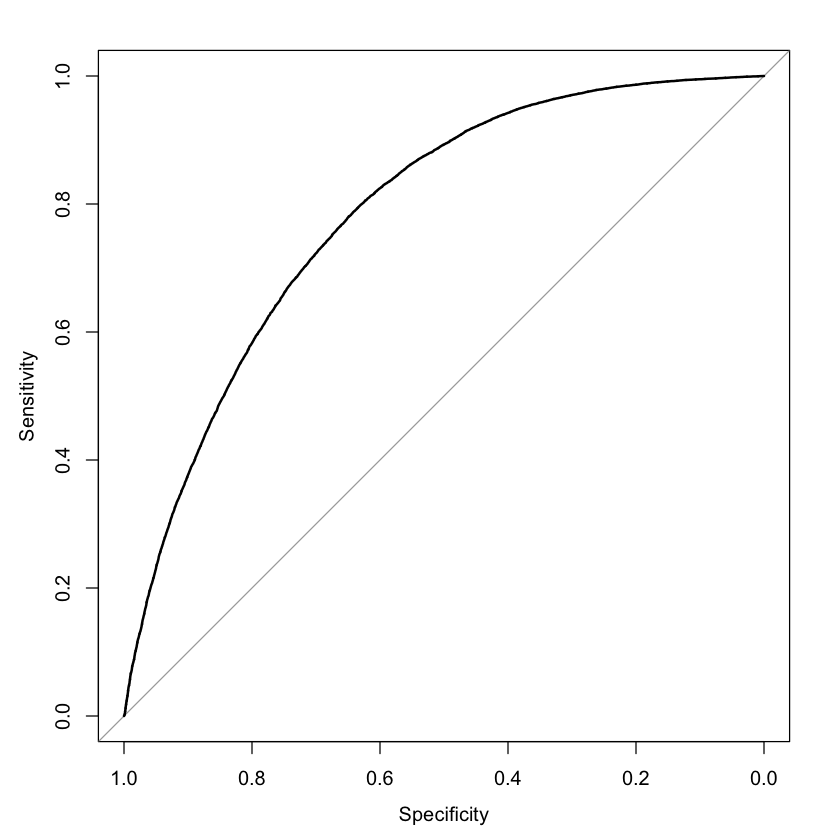

In [112]:
roc_curve <- roc(model2$y, fitted(model2)) 
par(bg = "white")
plot(roc_curve) 
print(paste("AUC:", round(auc(roc_curve), 3)))

##### Pseudo R-squared

In [107]:
descr::LogRegR2(model2)

Chi2                 15432.6 
Df                   20 
Sig.                 0 
Cox and Snell Index  0.2388178 
Nagelkerke Index     0.3184237 
McFadden's R2        0.1968431 

##### Deviance Ratio

In [108]:
ratio <- model2$deviance / model2$df.residual
# print(model2$deviance)
# print(model2$df.residual)
print(paste("Residual Deviance divided by DF:", round(ratio, 2)))

[1] "Residual Deviance divided by DF: 1.11"


- The ratio of 1.114 is slightly above 1, indicating mild overdispersion in your model

#### Influential observations

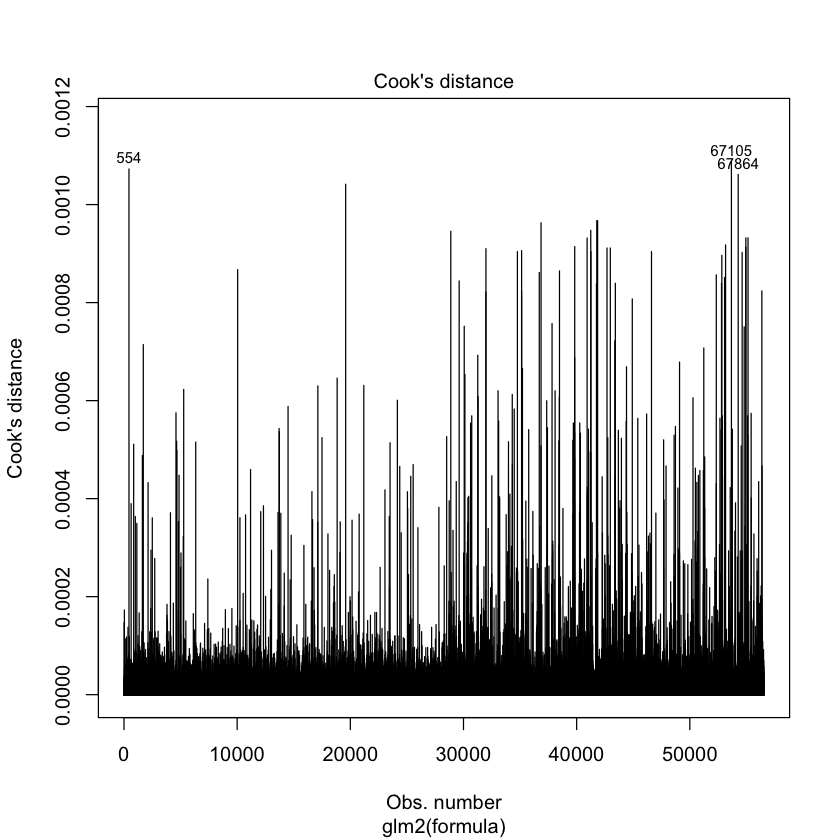

In [117]:
par(bg = "white")
plot(model2, which = 4, id.n = 3)

In [120]:
cooks_distances <- cooks.distance(model2)
influential_obs <- which(cooks_distances > 1)
print(influential_obs)

named integer(0)


- None of the observations are considered influential
- The model is stable with respect to the observations

### Model evaluation

In [76]:
model_evaluation <- function(model, data, target_name) {
    predicted_prob <- predict(model, newdata = data, type = "response")
    predict <- (predicted_prob >= 0.5)
    confusion_matrix <- table(data[[target_name]], predict)
    print("Confusion matrix: ")
    print(confusion_matrix)
    accuracy_test <- (confusion_matrix[1,1] + confusion_matrix[2,2])/nrow(data)
    print(paste("Accuracy: ", round(accuracy_test,4)))
    roc_curve <- roc(data[[target_name]], predicted_prob)
    auc_value <- auc(roc_curve)
    print(paste("AUC: ", round(auc_value, 4)))
}

In [77]:
model_evaluation(model2, df_test, target)

[1] "Confusion matrix: "
   predict
    FALSE TRUE
  0  4509 2560
  1  1525 5544
[1] "Accuracy:  0.7111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC:  0.7839"


In [78]:
model_evaluation(model3_final, df_test, target)

[1] "Confusion matrix: "
   predict
    FALSE TRUE
  0  4530 2539
  1  1540 5529
[1] "Accuracy:  0.7115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC:  0.7856"


* When comparing the accuracy and AUC of Model 2 and Model 3, Model 3 indeed does not have a much better performance

### Model interpretation

In [79]:
summary(model2)


Call:
glm2(formula = formula, family = binomial, data = df)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -5.222181   0.155654 -33.550  < 2e-16 ***
cvd                 1.298584   0.025235  51.460  < 2e-16 ***
Sex1                0.203548   0.019637  10.365  < 2e-16 ***
Age25-29           -0.012930   0.179822  -0.072    0.943    
Age30-34            0.242503   0.162169   1.495    0.135    
Age35-39            0.601723   0.154015   3.907 9.35e-05 ***
Age40-44            0.885917   0.150567   5.884 4.01e-09 ***
Age45-49            1.146344   0.148238   7.733 1.05e-14 ***
Age50-54            1.415157   0.146518   9.659  < 2e-16 ***
Age55-59            1.525555   0.145860  10.459  < 2e-16 ***
Age60-64            1.828774   0.145585  12.562  < 2e-16 ***
Age65-69            1.966110   0.145566  13.507  < 2e-16 ***
Age70-74            2.146132   0.146324  14.667  < 2e-16 ***
Age75-79            2.184707   0.147592  14.802  < 2e-16 ***
Age80 or 

In [80]:
adjusted_odd_ratio <- exp(cbind(OR = coef(model2), confint(model2)))

Waiting for profiling to be done...



In [81]:
print(adjusted_odd_ratio)

                            OR     2.5 %       97.5 %
(Intercept)        0.005395546 0.0039430  0.007263785
cvd                3.664103604 3.4876285  3.850269843
Sex1               1.225743964 1.1794727  1.273851180
Age25-29           0.987152751 0.6964156  1.410765996
Age30-34           1.274435368 0.9332979  1.763963130
Age35-39           1.825261770 1.3597358  2.489037173
Age40-44           2.425206162 1.8197196  3.286337215
Age45-49           3.146667828 2.3725497  4.245801665
Age50-54           4.117132699 3.1154131  5.537751159
Age55-59           4.597694493 3.4838189  6.176658531
Age60-64           6.226247791 4.7205418  8.360313360
Age65-69           7.142835950 5.4157036  9.590736133
Age70-74           8.551714150 6.4737430 11.498537955
Age75-79           8.888046654 6.7107261 11.978772401
Age80 or older     9.082292183 6.8583458 12.239274466
BMI                1.098327151 1.0947031  1.101985070
healthy_diet       0.852547079 0.8048753  0.902947184
PhysActivity1      0.7179737

- The odds of the outcome are 3.66 times higher for individuals with cardiovascular disease compared to those without cardiovascular disease
- There is 23% increase in odds of getting pre-diabetes or diabetes by male compared to female
- For age group, 
    - The odds of the outcome for individuals aged 35-39 are 1.82 times the odds of the individuals aged 18-24
    - The odds of the outcome for individuals aged 45-49 are 3.14 times the odds of the individuals aged 18-24
- For each one-unit increase in BMI, the odds of the outcome increase by 10%
- 15% reduction in odds of outcome by following a healthy diet
- 28% drop in odds of outcome by engaging in physical activity
- Having ever smoked is associated with a 1.17 times increase in the odds of the outcome
- Heavy alcohol consumption is associated with a decrease in the odds of the outcome by 0.41 times
- Failing to see a doctor because of money is associated with an increase in the odds of the outcome by 1.47 times

## Discussion
* Can try LASSO, but this requires a validation set to select the optimal regularisation parameter
* To further improve the performance, a neural network was fit. See the [project](https://github.com/wilsonwlc/Neural_network---Diabetes/blob/main/main.ipynb)